# Quantum Fourier Transform (QFT) in Quantum Computation Theory: Fourier Adder

Students often begin learning classical computing with the addition operation, let's take a look at the addition operation in the quantum world. In the context of the **Quantum Fourier Adder**, the QFT allows for the addition of a specified integer value to an arbitrary bitstring represented by a quantum state. This addition is performed efficiently in the Fourier basis, leveraging the principles of quantum mechanics to achieve computational advantages over classical algorithms for certain tasks.

Testing the addition operation on a quantum device involves several stages:
- Designing the quantum algorithm for addition  
- Quantum circuit implementation  
- Execution on quantum device
- Analysis and results validation


## 1. Purpose and Relevance

The Fourier Transform is essential in signal processing. The classical Fourier transform is used to decompose a complex-valued function `f(x)` into its constituent frequencies and their amplitudes, and inverse Fourier recreates `f(x)` from its transform [1]. It helps analyze frequencies, filter data, compress information, perform convolution and correlation, and conduct spectral analysis.  

Similarly, QFT holds great promise for signal processing when applied to quantum computing [2-5]. It opens new possibilities for applications in different fields in quantum information processing, for example:

- **Quantum Algorithm Design**: can be used as building block for quantum algorithms (Shor's algorithm for integer factorization, phase estimation, etc.)

- **Quantum Cryptography**: the method is used for quantum key distribution.

- **Quantum Simulation**: facilitates the simulation to study quantum materials, chemical reactions, and other complex quantum processesin of physical systems.

- **Error Correction**: QFT techniques are essential for developing quantum error correction codes, which are crucial for mitigating errors in quantum computations caused by noise and decoherence.  

## 2. Theory Behind Fourier Adder

**Quantum Fourier Transform (QFT)** is a quantum algorithm used to efficiently perform the Fourier transform on a quantum state. The default algorithm for benchmarking  quantum Fourier transform and inverse quantum Fourier transform when applying to the **Fourier Adder** operates as follows [2]:
- Initializes qubits with arbitrary bitstring.
- Converts to Fourier basis.
- Adds specified integer value in Fourier basis (e.g. +1).
- Converts back to measurement basis.
- Measures initial state plus added integer (x+1).

![image.png](images/Fig1_QFT_adder.png) 
*Fig.1. Circuit to benchmark Fourier Adder. Initialize inputs to a classical value , perform QFT, rotate the qubits to increase by 1 in the Fourier basis followed by the inverse QFT. It is expected that the measured output would match exactly the input value x+1 to the circuit. This method benchmarks the following circuit. Image sourse: [2]*

To apply Fourier Adder to particular state - we heed to prepare necessary state using State Circuit, which applies X gates to corresponding qubits.
State Circuit is visible on the right - green "Encoding x" part.

If we need to apply Fourier Adder to some other state - we can change the left part - keeping the right part consisting of QFT, Fourier Adder Circuit, Inverse QFT and Measurements.

Since only small left part changes for every particular state - we can efficiently apply Rivet Transpile Left function:

![image.png](images/Fig2_transpilation_time_comparison.png) 

*Fig.2. Transpilation times comparison for the basic transpilation and transpilation with Rivet function `transpile_left`.*

## 3. Installation and Imports


The **Rivet Transpiler** package provides a family of functions for the efficient transpilation of quantum circuits.  To benchmark the QFT for the case of addition operation the functions `transpile`, `transpile_left` and  `transpile_right` can be used.   



To run the code below make sure you have followed and installed Rivet transpiler. Check the installation steps from  **Readme.md**.


#### 3.1. Import Qiskit and Rivet Transpiler Functions Required to Run the Examples Below

To be able execute code below the `tqdm` should be installed:

In [1]:
# !pip install tqdm

In [2]:
### Import Qiskit

import qiskit
from qiskit.visualization import plot_gate_map
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

# General Imports

import numpy as np
from time import time
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use("dark_background") # optional, sets dark_background

### Import Rivet transpiler functions

%cd -q ../..
from rivet_transpiler import transpile, transpile_left

#### 3.2. Backend
Available backends from IBM Qiskit are listed at [6]. Some backend examples:
- 5-qubit backend with noise: `FakeLimaV2`
- 32-qubit backend with noise: `FakeMontrealV2` 

In [3]:
backend = FakeMontrealV2() 

# qiskit.visualization.plot_gate_map(backend)

![image.png](images/Fig3_FakeMonrealV2_backend.png)

*Fig.3. Schematic representation of the FakeMonrealV2 backend.*

#### 3.3. Define Functions
We define here the functions that will be used below.

- `build_state_circuit(state)` - constructs a quantum circuit that prepares a specific binary state.

- `build_qft_circuit(qubits_count)` - generates QFT circuit of a specified number of qubits.

- `build_fourrier_adder(qubits_count, number_to_add=1)` -  constructs a quantum circuit for a Fourier Adder operation.


In [4]:
def build_state_circuit(state):

    qubits_count = len(state)

    state_circuit = qiskit.QuantumCircuit(qubits_count)

    for index, bit in enumerate(state):

        if bit == "1":
            position = qubits_count - index - 1
            state_circuit.x(position)

    state_circuit.barrier(label="State")

    return state_circuit

In [5]:
def build_qft_circuit(qubits_count):

    qubits = list(range(qubits_count))

    circuit = qiskit.QuantumCircuit(qubits_count)

    for control_qubit in reversed(qubits):

        for target_qubit in reversed(range(control_qubit, qubits_count)):

            if control_qubit == target_qubit:

                circuit.h(control_qubit)

            else:

                theta = np.pi / 2 ** (target_qubit - control_qubit)

                circuit.crz(theta, control_qubit, target_qubit)

        circuit.barrier()

    return circuit

In [6]:
def build_fourier_adder(qubits_count, number_to_add=1):

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit in range(qubits_count):

        angle = number_to_add * (np.pi / 2 ** qubit)

        circuit.rz(angle, qubit)

    circuit.barrier(label="Adder")

    return circuit

## 4. Implementation  


### 4.1. Set up Circuits

In [7]:
# Set up parameters

QUBITS_COUNT = 5
NUMBER_TO_ADD = 2     #  number for addition operation, can set up any integer N

EXPERIMENTS_COUNT = 10
SHOTS_COUNT = 1000

OPTIMIZATION_LEVEL = 3
SEED = 1234

# States preparation

states_count = 2 ** QUBITS_COUNT
state_pattern = f">0{QUBITS_COUNT}b"

states = [f"{state:{state_pattern}}" for state in range(states_count)]
initial_states = states[:EXPERIMENTS_COUNT]

Prepares 3 quantum circuits: QFT circuit, inverse QFT circuit and a Fourier adder circuit (with a given `NUMBER_TO_ADD`).

In [8]:
qft_circuit = build_qft_circuit(QUBITS_COUNT)

inverted_qft_circuit = qft_circuit.inverse()

fourrier_adder = build_fourier_adder(QUBITS_COUNT, NUMBER_TO_ADD)

### 4.2. Transpilation Speed up with Rivet

Here the results for basic transpilation with Qiskit and Rivet compiler are compared. We demonstrate the significant speed up (number of experiments executed per second) in case of Rivet transpilation imprementation.

#### 4.2.1. Basic Transpilation with Qiskit

In [9]:
start_time = time()

# Compose and Transpile

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:

    state_circuit = build_state_circuit(initial_state)

    circuit = state_circuit.compose(qft_circuit)
    circuit = circuit.compose(fourrier_adder)
    circuit = circuit.compose(inverted_qft_circuit)

    circuit.measure_all()

    # display(circuit.draw(fold=-1))

    transpiled_circuit = qiskit.transpile(
        circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    transpiled_circuits.append(transpiled_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52 experiment/s]

estimated_time: 1.06


#### 4.2.2. Rivet Transpilation Using `transpile_left`

In [10]:
start_time = time()

# Transpile Central Part

central_circuit = qft_circuit.compose(fourrier_adder)
central_circuit = central_circuit.compose(inverted_qft_circuit)

central_circuit.measure_all()

transpiled_central_circuit = qiskit.transpile(
    central_circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)

# Transpile Left

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:

    state_circuit = build_state_circuit(initial_state)

    # display(circuit.draw(fold=-1))

    transpiled_circuit = transpile_left(
        transpiled_central_circuit,
        left_circuit=state_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    transpiled_circuits.append(transpiled_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.25 experiment/s]

estimated_time: 0.22


#### 4.2.3. Comparative Analysis of Transpilation Times

Here we use the `results` dataset to demonstrate how the transpilation time scales with the number of qubits in cases of basic **Qiskit** transpilation and **Rivet** transpilation using the `transpile_left` function.

In [11]:
results = {8: {'basic_transpilation': 389.1, 'transpile_left': 19.8},
           7: {'basic_transpilation': 231.29, 'transpile_left': 16.27},
           6: {'basic_transpilation': 169.55, 'transpile_left': 13.77},
           5: {'basic_transpilation': 123.55, 'transpile_left': 13.11},
           4: {'basic_transpilation': 88.25, 'transpile_left': 13.62},
           3: {'basic_transpilation': 55.11, 'transpile_left': 12.04},
           2: {'basic_transpilation': 25.7, 'transpile_left': 11.75}}

basic_times = [results[qubit_count]['basic_transpilation'] for qubit_count in results]  # with Qiskit
left_times = [results[qubit_count]['transpile_left'] for qubit_count in results]    # with Rivet

results

{8: {'basic_transpilation': 389.1, 'transpile_left': 19.8},
 7: {'basic_transpilation': 231.29, 'transpile_left': 16.27},
 6: {'basic_transpilation': 169.55, 'transpile_left': 13.77},
 5: {'basic_transpilation': 123.55, 'transpile_left': 13.11},
 4: {'basic_transpilation': 88.25, 'transpile_left': 13.62},
 3: {'basic_transpilation': 55.11, 'transpile_left': 12.04},
 2: {'basic_transpilation': 25.7, 'transpile_left': 11.75}}

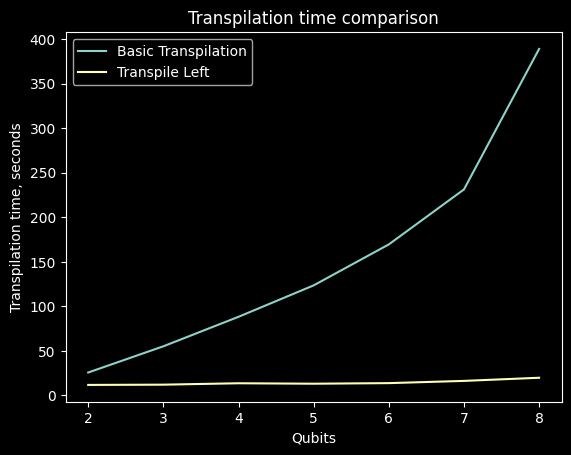

In [12]:
# Plot Transpilation times

qubit_counts = list(results.keys())

plt.title("Transpilation time comparison")
plt.xlabel("Qubits")
plt.ylabel("Transpilation time, seconds")

plt.plot(qubit_counts, basic_times, label="Basic Transpilation")   #with Qiskit
plt.plot(qubit_counts, left_times, label="Transpile Left")         #with Rivet

plt.legend()
plt.show()

### 4.3. Quantum Fourier Adder Results Verification

#### 4.3.1. Run the Circuit and Collect Measurements
We have to execute a set of transpiled quantum circuits, collects the measurement outcomes for each circuit, and stores them in `counts_list` for further analysis.

In [13]:
counts_list = []
transpiled_circuit_tracker = tqdm(transpiled_circuits, unit=' circuit', ncols=110)

for transpiled_circuit in transpiled_circuit_tracker:
    
    job = backend.run(transpiled_circuit, shots=SHOTS_COUNT)
    counts = job.result().get_counts()
    counts_list.append(counts)

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95 circuit/s]


#### 4.3.2. Compare Quantum States
To compare quantum states, store data for visualization we  define:

In [14]:
# Initial State Indices: Converts binary initial states into their corresponding integer indices
initial_state_indices = [int(initial_state, 2) for initial_state in initial_states]

# Top State Indices: Converts the binary representation of the top measured state into its integer index
top_state_indices = [int(max(counts, key=counts.get), 2) for counts in counts_list]

# Check that Addition works: Verifies that the addition operation on initial state indices and the specified number is correctly reflected in the top measured state indices
assert all((top_state_index == (initial_state_index + NUMBER_TO_ADD) % states_count)
           for initial_state_index, top_state_index in zip(initial_state_indices, top_state_indices))

# Global Counts: Constructs a 2D array (global_counts) to store counts data for each experiment and state index.
global_counts = np.array([[counts[state] if state in counts else 0
                           for state in states]
                          for counts in counts_list], dtype=int)

#### 4.3.3. Visualize Results

Visualize the counts obtained from the last iteration or experiment. The plot helps in analyzing the distribution of measurement outcomes and understanding the behavior of the quantum system.

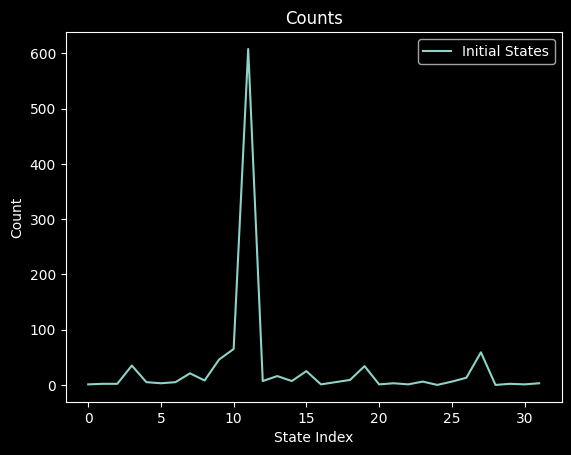

In [15]:
# Plot Last Counts

last_counts = global_counts[-1]

plt.title("Counts")
plt.xlabel("State Index")
plt.ylabel("Count")
plt.plot(last_counts, label="Initial States")
plt.legend()
plt.show()


Compare the initial and measured state (affter addition operation implementation) values.
**Expectations**: For the addition operation we set up `NUMBER_TO_ADD=2` so the different in state value should be 2.

In [16]:
# Plot State Comparison

plt.title("State Comparison")
plt.xlabel("State Index")
plt.ylabel("State Value")

plt.plot(initial_state_indices, label="Initial States")
plt.plot(top_state_indices, label="Measured States")

plt.legend()

# plt.show()
plt.close()

![image.png](images/Fig4_states_comparison.png) 

*Fig.4. States comparison for the initial and measured state (after addition operation implementation) values.*

Function `build_counts_figure` creates a 3D surface plot for visualizing state measurement results:

In [17]:
def build_counts_figure(initial_states, measured_states, counts,
                        elevation=10, initial_azimuth=230):

    initial_states_grid, measured_states_grid = np.meshgrid(initial_states, measured_states)

    figure, ax = plt.subplots(figsize=(5, 5),
                              subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_states_grid,
                              measured_states_grid,
                              counts.T,
                              cmap='plasma',
                              linewidth=30,
                              antialiased=True)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)

    ax.set_xlabel('Initial State Index')
    ax.set_ylabel('Measured State Index')
    ax.set_zlabel('Count', rotation=90)

    ax.patch.set_alpha(0)

    figure.patch.set_alpha(0)

    # figure.patch.set_facecolor('black')

    plt.close()

    return figure

Plot 3D surface for a subset of experiments:

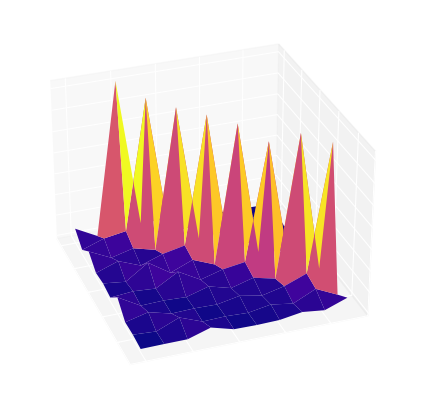

In [18]:
counts_figure = build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(EXPERIMENTS_COUNT),
    counts=global_counts[:,:EXPERIMENTS_COUNT],
    elevation=30,
    initial_azimuth=160+180
)

counts_figure

## 4. Conclusions

The implementation of the Quantum Fourier Adder algorithm was demonstrated, and significant speed enhancements were evident when using Rivet.

## References

[1] https://en.wikipedia.org/wiki/Fourier_transform

[2] https://github.com/SRI-International/QC-App-Oriented-Benchmarks/tree/master/quantum-fourier-transform

[3] IBM Research Report: An Approximate Fourier Transform Useful in Quantum Factoring https://arxiv.org/pdf/quant-ph/0201067.pdf

[4] https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

[5] Michael A. Nielsen and Isaac L. Chuang. (2011). Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA.

[6] Qiskit fake backends https://docs.quantum.ibm.com/api/qiskit/0.37/providers_fake_provider